In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
#from matplotlib.pylab import rcParams
#plt.style.use('fivethirtyeight')
#rcParams['figure.figsize'] = 50,20
#rcParams['font.size'] = 30

In [ ]:
tf.random.set_seed(1234)

In [ ]:
file = '/content/winterriver_01CC002_Q_model.xlsx'
raw_data = pd.read_excel(file, parse_dates = ['Date'],
                       index_col = 'Date')
df = raw_data.copy()

In [ ]:
df=df[["Flow(m3/s)","Mean Temp (°C)","Level(m)"]][0:1826]
df.head()

,Flow(m3/s),Mean Temp (°C),Level(m)
Date,,,
2015-01-01,1.37,-9.3,1.245
2015-01-02,1.37,-7.1,1.244
2015-01-03,1.27,-14.0,1.230
2015-01-04,1.28,-2.8,1.231
2015-01-05,1.40,-4.6,1.249


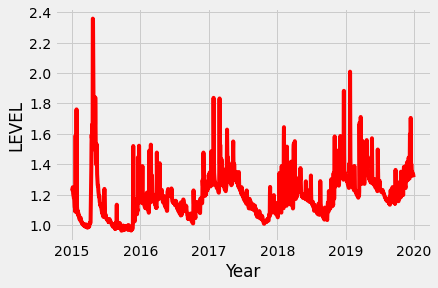

In [ ]:
def timeseries (x_axis, y_axis, x_label, y_label):
    #plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='red')
    plt.xlabel(x_label ) 
    plt.ylabel(y_label)
timeseries(df.index, df['Level(m)'], 'Year','LEVEL')

In [ ]:
trainset = df[:"2017"]
trainset

,Flow(m3/s),Mean Temp (°C),Level(m)
Date,,,
2015-01-01,1.370,-9.3,1.245
2015-01-02,1.370,-7.1,1.244
2015-01-03,1.270,-14.0,1.230
2015-01-04,1.280,-2.8,1.231
2015-01-05,1.400,-4.6,1.249
...,...,...,...
2017-12-27,0.113,-10.0,1.112
2017-12-28,0.100,-14.9,1.091
2017-12-29,0.092,-10.0,1.077


In [ ]:
testset = df["2018":]
testset

,Flow(m3/s),Mean Temp (°C),Level(m)
Date,,,
2018-01-01,0.088,-13.9,1.065
2018-01-02,0.087,-14.5,1.063
2018-01-03,0.087,-11.7,1.057
2018-01-04,0.086,0.6,1.051
2018-01-05,0.086,-4.2,1.084
...,...,...,...
2019-12-27,1.070,-4.7,1.331
2019-12-28,1.100,-0.3,1.335
2019-12-29,1.030,-3.2,1.323


Dimension of train data:  (1096, 3)
Dimension of test data:  (730, 3)


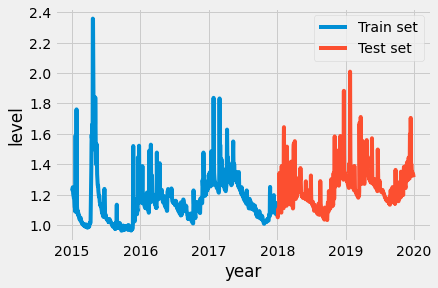

In [ ]:
#plt.figure(figsize = (10, 6))
plt.plot(trainset["Level(m)"])
plt.plot(testset["Level(m)"])
plt.xlabel('year')
plt.ylabel('level')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',trainset.shape)
print('Dimension of test data: ', testset.shape)

In [ ]:
# Split train data to X and y
X_train = trainset.drop('Level(m)', axis = 1)
y_train = trainset.loc[:,['Level(m)']]
# Split test data to X and y
X_test = testset.drop('Level(m)', axis = 1)
y_test = testset.loc[:,['Level(m)']]

In [ ]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [ ]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 1

X_test, y_test = create_dataset(test_x_norm, test_y_norm,TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm,TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (729, 1, 2)
y_train.shape:  (1095, 1)
X_test.shape:  (729, 1, 2)
y_test.shape:  (1095, 1)


In [ ]:
1# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(128)
# GRU and LSTM
model_gru = create_model(128, GRU)


In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 150,  
                        validation_split = 0.2, batch_size = 10, 
                        shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)

history_gru = fit_model(model_gru)

Epoch 1/150
88/88 [==============================] - 10s 34ms/step - loss: 0.0163 - val_loss: 0.0220
Epoch 2/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0127 - val_loss: 0.0158
Epoch 3/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0106 - val_loss: 0.0125
Epoch 4/150
88/88 [==============================] - 1s 14ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 5/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 6/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0066 - val_loss: 0.0098
Epoch 7/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0065 - val_loss: 0.0099
Epoch 8/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 9/150
88/88 [==============================] - 1s 10ms/step - loss: 0.0063 - val_loss: 0.0093
Epoch 10/150
88/88 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.009

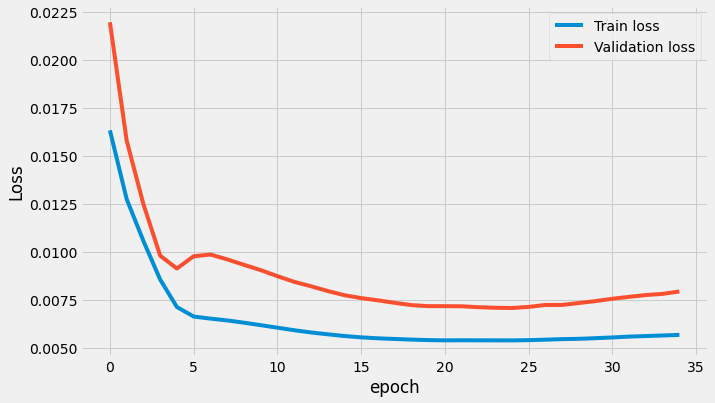

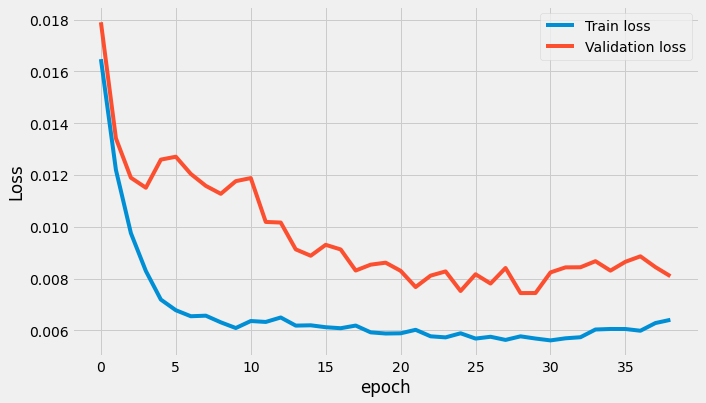

In [ ]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_bilstm)
plot_loss (history_gru)

In [ ]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

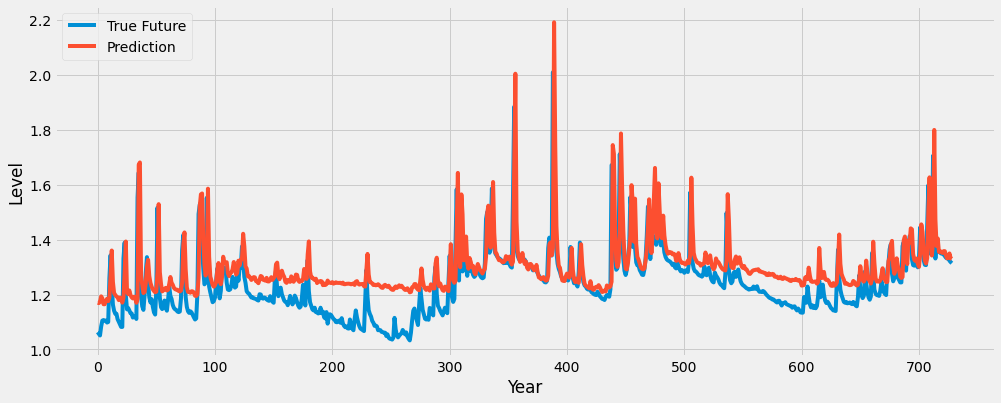

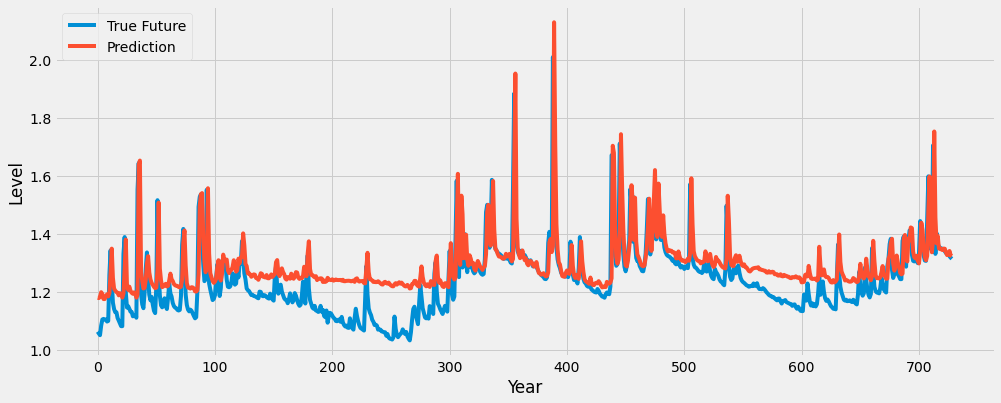

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(15, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Year')
    plt.ylabel('Level')
plot_future(prediction_bilstm, y_test)
plot_future(prediction_gru, y_test)

In [ ]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Mean Square Error:{:.4f}'.format(mse))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 0.0779
Mean Square Error:0.0105
Root Mean Square Error: 0.1027
GRU:
Mean Absolute Error: 0.0751
Mean Square Error:0.0099
Root Mean Square Error: 0.0994


In [ ]:
pred =prediction_bilstm.reshape(-1)
pred1 =prediction_gru.reshape(-1)


In [ ]:
pred1


array([0.6257294 , 0.6264049 , 0.6219287 , 0.60057634, 0.69922215,
       0.70990604, 0.6793788 , 0.66032624, 0.6444686 , 0.64319026,
       0.6634028 , 1.164484  , 0.834756  , 0.6941559 , 0.65248525,
       0.6419058 , 0.637214  , 0.63379616, 0.6313923 , 0.6277306 ,
       0.61945546, 0.6305342 , 0.65123653, 1.1039126 , 0.6777673 ,
       0.6497045 , 0.63555396, 0.66524976, 0.6525481 , 0.6324114 ,
       0.6284451 , 0.61920726, 0.62414294, 0.6513376 , 0.64630187,
       1.3519467 , 0.9039634 , 0.6793477 , 0.6475227 , 0.63784677,
       0.64457923, 0.7481555 , 0.72941536, 0.72067034, 0.6594094 ,
       0.63969386, 0.65191436, 0.67597765, 0.6416369 , 0.6313407 ,
       0.63102937, 0.9420446 , 1.0144551 , 0.6722452 , 0.66359997,
       0.6622339 , 0.6535111 , 0.7013512 , 0.6847196 , 0.63497657,
       0.65043056, 0.76185846, 0.7128907 , 0.6618028 , 0.66071874,
       0.63257235, 0.62690467, 0.62569857, 0.62542814, 0.6221712 ,
       0.62175894, 0.61886615, 0.62266153, 0.6408999 , 0.65319

In [ ]:
pred

array([0.6102249 , 0.6104827 , 0.6077786 , 0.5927901 , 0.6995365 ,
       0.6992548 , 0.66638005, 0.6520838 , 0.63846684, 0.63281685,
       0.6622086 , 1.1735766 , 0.85434854, 0.6917202 , 0.6459321 ,
       0.63512444, 0.6298808 , 0.62455934, 0.6192471 , 0.6201027 ,
       0.6099639 , 0.6150383 , 0.6467496 , 1.1105968 , 0.6798966 ,
       0.6379122 , 0.6282593 , 0.6669652 , 0.64690745, 0.6234082 ,
       0.6162932 , 0.6111059 , 0.61553663, 0.63660336, 0.63865   ,
       1.254276  , 0.911665  , 0.67703557, 0.6430013 , 0.6269766 ,
       0.63883054, 0.75485677, 0.7351693 , 0.717357  , 0.65553117,
       0.6376295 , 0.649836  , 0.66937923, 0.63466436, 0.6252336 ,
       0.6271501 , 0.9618722 , 1.0240772 , 0.6679818 , 0.6632482 ,
       0.65741706, 0.6508254 , 0.7045726 , 0.6827849 , 0.6290145 ,
       0.6497458 , 0.7727366 , 0.71781653, 0.6615626 , 0.6596995 ,
       0.62821823, 0.62218267, 0.62081647, 0.6208785 , 0.6165252 ,
       0.6154699 , 0.6131401 , 0.61911607, 0.6395253 , 0.65063

In [ ]:
#pred.to_csv("bilstm")
#pred1.to_csv('gru')

In [ ]:
actual=testset["Level(m)"][0:729]

In [ ]:
pip install hydroeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import hydroeval as he

In [ ]:
nse_bilstm = he.evaluator(he.nse,pred,actual)

In [ ]:
nse_bilstm

array([0.93466825])

In [ ]:
nse_gru = he.evaluator(he.nse,pred1,actual)

In [ ]:
nse_gru

array([0.94064741])